In [1]:
%load_ext autoreload
%autoreload 2
import sys 
from FR3Py.robot.interface import FR3Real
robot = FR3Real(robot_id='fr3')

Interface Running...


In [3]:
robot.getStates()

{'q': array([ 6.57267383e-04, -7.85027556e-01,  2.72633056e-03, -2.36906629e+00,
        -6.26780615e-04,  1.56980683e+00,  7.86098426e-01]),
 'dq': array([ 0.00153706, -0.00062384,  0.00036235, -0.00135244,  0.00021293,
        -0.00048918, -0.00107173]),
 'T': array([-0.15939641, -4.06793356, -0.90254819, 23.11954117,  1.07591474,
         2.38034797, -0.0507867 ])}

In [4]:
import numpy as np
from FR3Py.robot.model_collision_avoidance import PinocchioModel
import time

pin_robot = PinocchioModel()
joint_lb = np.array([-2.3093, -1.5133, -2.4937, -2.7478, -2.48, 0.8521, -2.6895])
joint_ub = np.array([2.3093, 1.5133, 2.4937, -0.4461, 2.48, 4.2094, 2.6895])
n_joints = 7
q_bar = 0.5*(joint_ub + joint_lb)
P_EE_pre_wiping = np.array([0.42, 0.50, 0.0])
R_EE_desired = np.array([[1, 0, 0],
                        [0, -1, 0],
                        [0, 0, -1]])
P_EE_initial = np.array([0.30, 0.0, 0.47])

### Inverse dynamic control (initial pose to pre-cleaning pose)

In [5]:
from cores.utils.trajectory_utils import TrapezoidalTrajectory

via_points = np.array([P_EE_initial, P_EE_pre_wiping])
target_time = np.array([0, 10])
traj = TrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=0.01)

In [7]:
from liegroups import SO3

T = 12

R_d = np.array([[1, 0, 0],
                [0, -1, 0],
                [0, 0, -1]])

K_p_pos = np.diag([100,100,100])
K_d_pos = np.diag([50,50,50])

K_p_rot = np.diag([100,100,100])
K_d_rot = np.diag([50,50,50])

Kp_joint = 20*np.diag([1, 1, 1, 1, 1, 1, 1])
Kd_joint = 10*np.diag([1, 1, 1, 1, 1, 1, 1])

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_vel, traj_acc = traj.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + 0.1*np.eye(n_joints) # shape (7,7)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    e_pos_dt = v_EE[:3] - traj_vel # shape (3,)
    v_dt = traj_acc - K_p_pos @ e_pos - K_d_pos @ e_pos_dt

    e_rot = SO3(R_EE @ R_d.T).log() # shape (3,)
    e_rot_dt = v_EE[3:] # shape (3,)
    omega_dt = -K_p_rot @ e_rot - K_d_rot @ e_rot_dt

    v_EE_dt_desired = np.concatenate([v_dt, omega_dt])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    q_dtdt_task = S_pinv @ (v_EE_dt_desired - dJdq_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q - q_bar)
    e_joint_dot = W @ dq
    q_dtdt = q_dtdt_task + S_null @ (- Kp_joint @ e_joint - Kd_joint @ e_joint_dot)

    # Map to torques
    u = M @ q_dtdt
    
    u = np.clip(u, -20, 20)
    robot.setCommands(u)

robot.setCommands(np.zeros_like(u))


### Press against the surface while tracking a circular trajectory with friction compensation

In [43]:
from cores.utils.trajectory_utils import CircularTrajectory
duration = 100
start_time = 0
end_time = start_time + duration
dist_to_surface = -0.005
P_start_point = np.array([0.42, 0.50, dist_to_surface])
P_center = np.array([0.32, 0.50, dist_to_surface])
nominal_linear_vel = 0.05
R_b_to_w = np.eye(3)
traj = CircularTrajectory(P_center, P_start_point, nominal_linear_vel, R_b_to_w, start_time, end_time)


In [44]:
T = 60

K_p_pos = np.diag([100,100,50])
K_d_pos = np.diag([50,50,25])

K_p_rot = np.diag([200,200,200])
K_d_rot = np.diag([100,100,100])

Kp_joint = 10*np.diag([1, 1, 1, 1, 1, 1, 1])
Kd_joint = 5*np.diag([1, 1, 1, 1, 1, 1, 1])

F_press = np.array([0, 0, 0, 0, 0, 0])

mu_friction = 0.305

# Records
pos_list = []
u_list = []
t_list = []

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_vel, traj_acc = traj.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    tau_m = robot_info["T"] # shape (6,)
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + 0.1*np.eye(n_joints) # shape (7,7)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)
    tau_ext = tau_m - nle

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    e_pos_dt = v_EE[:3] - traj_vel # shape (3,)
    v_dt = traj_acc - K_p_pos @ e_pos - K_d_pos @ e_pos_dt

    e_rot = SO3(R_EE @ R_d.T).log() # shape (3,)
    e_rot_dt = v_EE[3:] # shape (3,)
    omega_dt = -K_p_rot @ e_rot - K_d_rot @ e_rot_dt

    v_EE_dt_desired = np.concatenate([v_dt, omega_dt])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    q_dtdt_task = S_pinv @ (v_EE_dt_desired - dJdq_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q - q_bar)
    e_joint_dot = W @ dq
    q_dtdt = q_dtdt_task + S_null @ (- Kp_joint @ e_joint - Kd_joint @ e_joint_dot)

    # Other objective 1: apply a force on the z axis to press the end-effector against the table
    u_press = J_EE.T @ F_press

    # Other objective 2: apply a force to compensate for the friction
    F_ext = np.linalg.pinv(J_EE.T) @ tau_ext
    z_force = F_ext[2]
    F_friction = np.zeros(6)
    if z_force < 0 and np.linalg.norm(v_EE[0:2]) > 0.01:
        friction = mu_friction * np.abs(z_force)
        direction = v_EE[0:2]/np.linalg.norm(v_EE[0:2])
        F_friction[0:2] = direction * friction
    if z_force < 0 and abs(v_EE[5]) > 0.01:
        F_friction[5] = np.sign(v_EE[5]) * mu_friction * abs(z_force) * 0.03534
    u_friction = J_EE.T @ F_friction

    # Map to torques
    u = M @ q_dtdt + u_press + u_friction
    u = np.clip(u, -10, 10)
    robot.setCommands(u)

    t_list.append(t)
    pos_list.append(P_EE)
    u_list.append(u)

robot.setCommands(np.zeros_like(u))


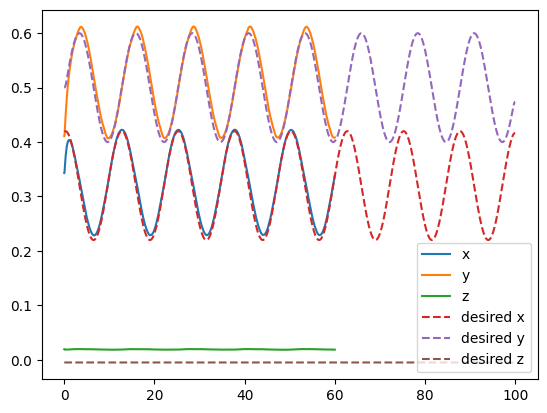

In [45]:
import matplotlib.pyplot as plt

pos_list = np.array(pos_list)
u_list = np.array(u_list)
t_list = np.array(t_list)

plt.figure()
plt.plot(t_list, pos_list[:,0], label='x')
plt.plot(t_list, pos_list[:,1], label='y')
plt.plot(t_list, pos_list[:,2], label='z')
plt.plot(traj.t, traj.pd[:,0], '--', label='desired x')
plt.plot(traj.t, traj.pd[:,1], '--', label='desired y')
plt.plot(traj.t, traj.pd[:,2], '--', label='desired z')
plt.legend()



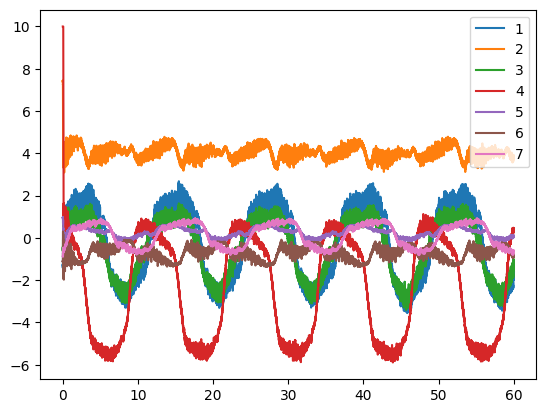

In [46]:

plt.figure()
plt.plot(t_list, u_list[:,0], label='1')
plt.plot(t_list, u_list[:,1], label='2')
plt.plot(t_list, u_list[:,2], label='3')
plt.plot(t_list, u_list[:,3], label='4')
plt.plot(t_list, u_list[:,4], label='5')
plt.plot(t_list, u_list[:,5], label='6')
plt.plot(t_list, u_list[:,6], label='7')

plt.legend()


### Recover to initial pose

In [47]:
via_points = np.array([P_EE, np.array([P_EE[0], P_EE[1], P_EE[2]+0.2])])
target_time = np.array([0, 5])
traj = TrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=0.01)

In [48]:
from liegroups import SO3

T = 7

K_p_pos = np.diag([100,100,100])
K_d_pos = np.diag([50,50,50])

K_p_rot = np.diag([100,100,100])
K_d_rot = np.diag([50,50,50])

Kp_joint = 20*np.diag([1, 1, 1, 1, 1, 1, 1])
Kd_joint = 10*np.diag([1, 1, 1, 1, 1, 1, 1])

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_vel, traj_acc = traj.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + 0.1*np.eye(n_joints) # shape (7,7)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    e_pos_dt = v_EE[:3] - traj_vel # shape (3,)
    v_dt = traj_acc - K_p_pos @ e_pos - K_d_pos @ e_pos_dt

    e_rot = SO3(R_EE @ R_d.T).log() # shape (3,)
    e_rot_dt = v_EE[3:] # shape (3,)
    omega_dt = -K_p_rot @ e_rot - K_d_rot @ e_rot_dt

    v_EE_dt_desired = np.concatenate([v_dt, omega_dt])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    q_dtdt_task = S_pinv @ (v_EE_dt_desired - dJdq_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q - q_bar)
    e_joint_dot = W @ dq
    q_dtdt = q_dtdt_task + S_null @ (- Kp_joint @ e_joint - Kd_joint @ e_joint_dot)

    # Map to torques
    u = M @ q_dtdt
    
    u = np.clip(u, -20, 20)
    robot.setCommands(u)

robot.setCommands(np.zeros_like(u))
